In [22]:
from matplotlib import pyplot as plt
# import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
import tensorflow as tf
import pickle
import json


%matplotlib inline

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [35]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
r"""Downloads and converts Flowers data to TFRecords of TF-Example protos.

This module downloads the Flowers data, uncompresses it, reads the files
that make up the Flowers data and creates two TFRecord datasets: one for train
and one for test. Each TFRecord dataset is comprised of a set of TF-Example
protocol buffers, each of which contain a single image and label.

The script should take about a minute to run.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
# import random
import sys

# import tensorflow as tf

from datasets import dataset_utils

# The URL where the Flowers data can be downloaded.
# _DATA_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'

# The number of images in the validation set.
_NUM_VALIDATION = 2750

# Seed for repeatability.
_RANDOM_SEED = 0

# The number of shards per dataset split.
_NUM_SHARDS = 5


class ImageReader(object):
    """Helper class that provides TensorFlow image coding utilities."""

    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg,
                         feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image


def _get_filenames_and_classes(dataset_dir):
    """Returns a list of filenames and inferred class names.

    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.

    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
    fish_root = os.path.join(dataset_dir, 'train')
    directories = []
    class_names = []
    for filename in os.listdir(fish_root):
        path = os.path.join(fish_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

#     photo_lst = []
#     for directory in directories:
#         lst_temp = []
#         for filename in os.listdir(directory):
#             if filename.split('.')[-1] in ['jpg', 'png', 'jepg']:
#                 path = os.path.join(directory, filename)
#                 lst_temp.append(path)
#         photo_lst.append(lst_temp)

#     photo_filenames = []
#     for i in range(len(photo_lst[0])):
#         for j in range(len(photo_lst)):
#             index = j%(len(photo_lst[j]))
#             photo_filenames.append(photo_lst[j][index])

    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.split('.')[-1] in ['jpg', 'png', 'jepg']:
                path = os.path.join(directory, filename)
                photo_filenames.append(path)
        
    return photo_filenames, sorted(class_names)


def _get_dataset_filename(dataset_dir, split_name, shard_id):
    output_filename = 'fish_%s_%05d-of-%05d.tfrecord' % (
        split_name, shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

def _get_bb():
    label_files = ['./label/bet_labels.json',
                 './label/alb_labels.json',
                 './label/yft_labels.json',
                 './label/dol_labels.json',
                 './label/shark_labels.json',
                 './label/lag_labels.json',
                 './label/other_labels.json']
    labels = []
    for i in range(len(label_files)):
        label_file = label_files[i]
        with open(label_file, 'r') as f:
            label_json = json.load(f)
        # extend 合并dict
        labels.extend(label_json)
    return labels

def _convert_dataset(split_name, filenames, bb_labels, class_names_to_ids, dataset_dir):
    """Converts the given filenames to a TFRecord dataset.

    Args:
    split_name: The name of the dataset, either 'train' or 'validation'.
    filenames: A list of absolute paths to png or jpg images.
    class_names_to_ids: A dictionary from class names (strings) to ids
      (integers).
    dataset_dir: The directory where the converted datasets are stored.
    """
    assert split_name in ['train', 'validation']

    num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))
        
    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:
            for shard_id in range(_NUM_SHARDS):
                output_filename = _get_dataset_filename(dataset_dir, split_name, shard_id)

                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = shard_id * num_per_shard
                    end_ndx = min((shard_id+1) * num_per_shard, len(filenames))
                    for i in range(start_ndx, end_ndx):
                        sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                            i+1, len(filenames), shard_id))
                        sys.stdout.flush()

                        # Read the filename:
                        image_data = tf.gfile.FastGFile(filenames[i], 'r').read()
                        height, width = image_reader.read_image_dims(sess, image_data)

                        try:
                            bb_label_index = next(index for (index, d) in enumerate(bb_labels) 
                                                  if d["filename"] == filenames[i].split(os.sep)[-1])
                            bb_label = bb_labels[bb_label_index]['annotations']
                            bb_label = json.dumps(bb_label)
                            bb_label = bytes(bb_label, 'utf-8')
                        except:
                            bb_label = b''

                        class_name = os.path.basename(os.path.dirname(filenames[i]))
                        class_id = class_names_to_ids[class_name]

                        example = dataset_utils.image_to_tfexample(
                            image_data, b'jpg', height, width, class_id, bb_label)
                        tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()


def _clean_up_temporary_files(dataset_dir):
    """Removes temporary files used to create the dataset.

    Args:
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = _DATA_URL.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)
    tf.gfile.Remove(filepath)

    tmp_dir = os.path.join(dataset_dir, 'flower_photos')
    tf.gfile.DeleteRecursively(tmp_dir)


def _dataset_exists(dataset_dir):
    for split_name in ['train', 'validation']:
        for shard_id in range(_NUM_SHARDS):
            output_filename = _get_dataset_filename(
                dataset_dir, split_name, shard_id)
            if not tf.gfile.Exists(output_filename):
                return False
    return True


def run(dataset_dir):
    """Runs the download and conversion operation.

    Args:
    dataset_dir: The dataset directory where the dataset is stored.
    """
    if not tf.gfile.Exists(dataset_dir):
        tf.gfile.MakeDirs(dataset_dir)

    if _dataset_exists(dataset_dir):
        print('Dataset files already exist. Exiting without re-creating them.')
        return

#     dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)
    photo_filenames, class_names = _get_filenames_and_classes(dataset_dir)
    class_names_to_ids = dict(zip(class_names, range(len(class_names))))

    # Divide into train and test:
    random.seed(_RANDOM_SEED)
    random.shuffle(photo_filenames)
    training_filenames = photo_filenames[_NUM_VALIDATION:]
    validation_filenames = photo_filenames[:_NUM_VALIDATION]
    
    bb_labels = _get_bb()

    # First, convert the training and validation sets.
    _convert_dataset('train', training_filenames, bb_labels, class_names_to_ids, dataset_dir)
    _convert_dataset('validation', validation_filenames, bb_labels, class_names_to_ids, dataset_dir)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(class_names)), class_names))
    dataset_utils.write_label_file(labels_to_class_names, dataset_dir)

#     _clean_up_temporary_files(dataset_dir)
    print('\nFinished converting the fish dataset!')



In [36]:
run('./input/')

>> Converting image 1027/1027 shard 4
>> Converting image 2750/2750 shard 4

Finished converting the fish dataset!


In [37]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Provides data for the fish dataset.

The dataset scripts used to create the dataset can be found at:
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf

from datasets import dataset_utils

slim = tf.contrib.slim

_FILE_PATTERN = 'fish_%s_*.tfrecord'

SPLITS_TO_SIZES = {'train': 11002, 'validation': 2750, 'test': 1000}

_NUM_CLASSES = 8

_ITEMS_TO_DESCRIPTIONS = {
    'image': 'A color image of varying size.',
    'label': 'A single integer between 0 and 7',
    'bb_label': 'A list of boundary boxes'
}


def get_split(split_name, dataset_dir, file_pattern=None, reader=None):
    """Gets a dataset tuple with instructions for reading fish.

    Args:
    split_name: A train/validation split name.
    dataset_dir: The base directory of the dataset sources.
    file_pattern: The file pattern to use when matching the dataset sources.
      It is assumed that the pattern contains a '%s' string so that the split
      name can be inserted.
    reader: The TensorFlow reader type.

    Returns:
    A `Dataset` namedtuple.

    Raises:
    ValueError: if `split_name` is not a valid train/validation split.
    """
    if split_name not in SPLITS_TO_SIZES:
        raise ValueError('split name %s was not recognized.' % split_name)

    if not file_pattern:
        file_pattern = _FILE_PATTERN
        file_pattern = os.path.join(dataset_dir, file_pattern % split_name)

    # Allowing None in the signature so that dataset_factory can use the default.
    if reader is None:
        reader = tf.TFRecordReader

    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
        'image/class/label': tf.FixedLenFeature(
            [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
        'image/bb_label': tf.FixedLenFeature((), tf.string, default_value=b''),
    }

    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(),
        'label': slim.tfexample_decoder.Tensor('image/class/label'),
        'bb_label': slim.tfexample_decoder.Tensor('image/bb_label'),
    }

    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)

    labels_to_names = None
    if dataset_utils.has_labels(dataset_dir):
        labels_to_names = dataset_utils.read_label_file(dataset_dir)

    return slim.dataset.Dataset(
        data_sources=file_pattern,
        reader=reader,
        decoder=decoder,
        num_samples=SPLITS_TO_SIZES[split_name],
        items_to_descriptions=_ITEMS_TO_DESCRIPTIONS,
        num_classes=_NUM_CLASSES,
        labels_to_names=labels_to_names)


In [ ]:
# fish_data_dir = 'tmp/fish/dataset'
# colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

# with tf.Graph().as_default(): 
#     dataset = get_split('train', fish_data_dir)
#     data_provider = slim.dataset_data_provider.DatasetDataProvider(
#         dataset, common_queue_capacity=32, common_queue_min=8)
#     image, label, bb_label = data_provider.get(['image', 'label', 'bb_label'])
    
#     with tf.Session() as sess:    
#         with slim.queues.QueueRunners(sess):
#             for i in range(5):
#                 np_image, np_label, np_bb_label = sess.run([image, label, bb_label])
#                 height, width, _ = np_image.shape
#                 class_name = name = dataset.labels_to_names[np_label]
                
# #                 from PIL import Image
# #                 Image.fromarray(np_image)
                
#                 plt.figure()
#                 plt.imshow(np_image)
#                 currentAxis = plt.gca()
#                 j = 0
#                 if np_bb_label is not b'':
#                     np_bb_label_lst = json.loads((np_bb_label.decode('utf-8')))
#                     for rect in np_bb_label_lst:
#                         _x, _y, _width, _height = rect['x'], rect['y'], rect['width'], rect['height']
#                         coords = (_x*width, _y*height), _width*width, _height*height
#                         currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[np_label], linewidth=2))
#                         j += 1
#                 plt.title('%s, %d x %d' % (name, height, width))
#                 plt.axis('off')
#                 plt.show()

In [ ]:
#count images without bb_label


# filenames, classes = _get_filenames_and_classes('input')
# bb_labels = _get_bb()
# count = 0
# for path in filenames:
#     filename = path.split(os.sep)[-1]
#     if not any(d['filename'] == filename for d in bb_labels):
#         count += 1
#         print(path)

In [38]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """

    data_provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset, common_queue_capacity=batch_size*3,
    common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels



In [39]:
# Note that this may take several minutes!!
# Fine-tune pre-trained netoworks.

import os

from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim
image_size = inception.inception_v3.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
    
    return slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
        variables_to_restore)


train_dir = 'tmp/fish/inception_finetuned/'
fish_data_dir = 'tmp/fish/dataset'
checkpoints_dir = 'tmp/fish/my_checkpoints'
batch_size = 16
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('train', fish_data_dir)
    
    images, _, labels = load_batch(dataset, height=image_size, width=image_size, batch_size=batch_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    with tf.device('/cpu:0'):
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    # GPU error on incepton-v3 because of motherboard: "failed to query event: CUDA_ERROR_LAUNCH_FAILED,Unexpected Event status: 1"

#     config = tf.ConfigProto(device_count = {'gpu': 0})
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

# windows 查看tensorflow/contrib/slim/python/slim/learning.py 中的 start_standard_services = False
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=50,
        session_config=config,)
        
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 2.1267 (4.93 sec/step)
INFO:tensorflow:global step 2: loss = 2.2866 (2.89 sec/step)
INFO:tensorflow:global step 3: loss = 1.8848 (1.66 sec/step)
INFO:tensorflow:global step 4: loss = 2.1316 (1.66 sec/step)
INFO:tensorflow:global step 5: loss = 1.5718 (4.06 sec/step)
INFO:tensorflow:global step 6: loss = 1.7888 (1.61 sec/step)
INFO:tensorflow:global step 7: loss = 1.9595 (1.67 sec/step)
INFO:tensorflow:global step 8: loss = 1.5601 (1.58 sec/step)
INFO:

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.


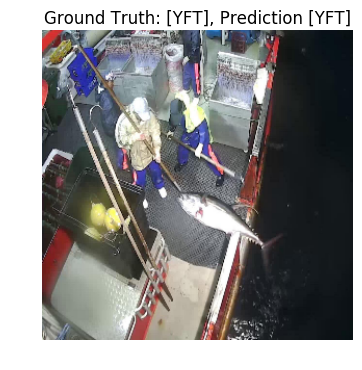

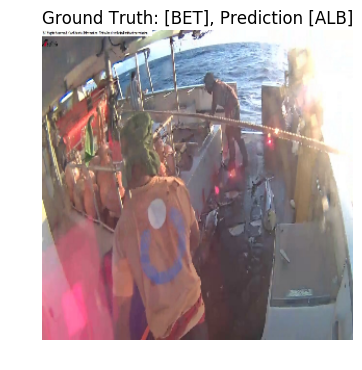

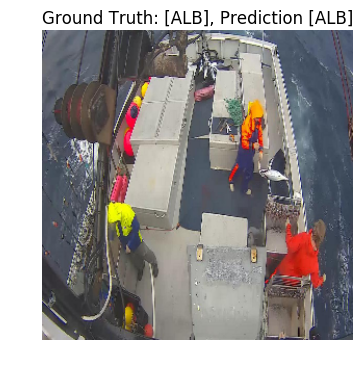

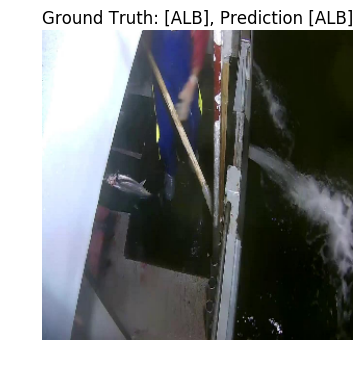

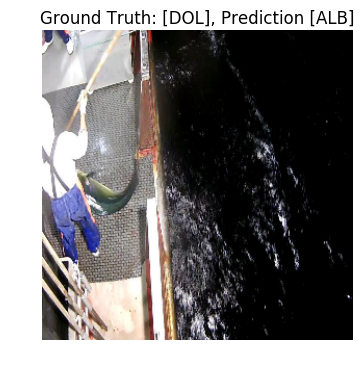

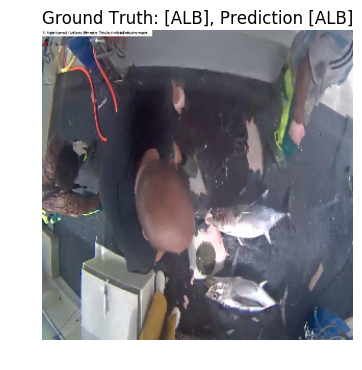

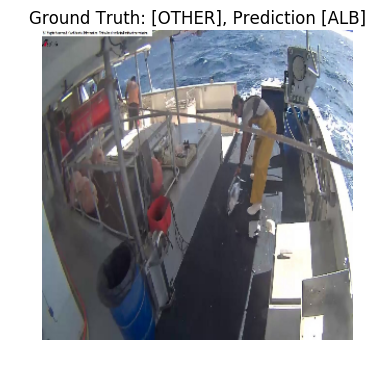

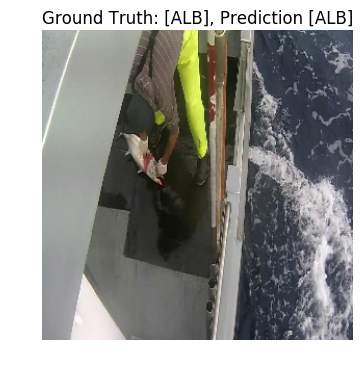

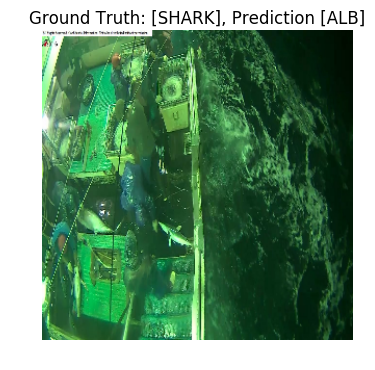

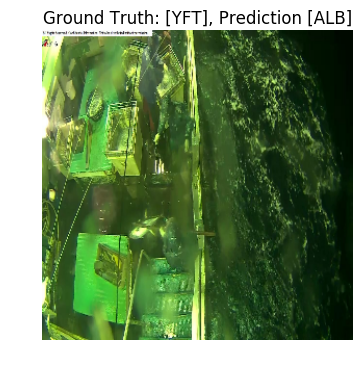

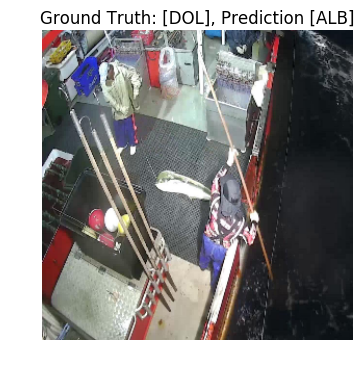

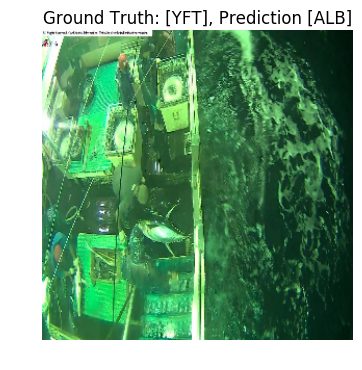

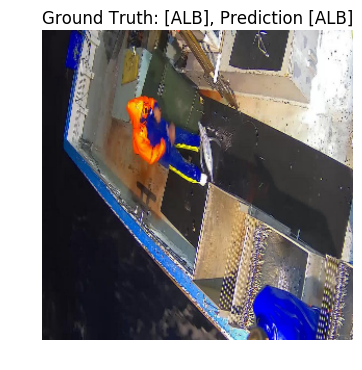

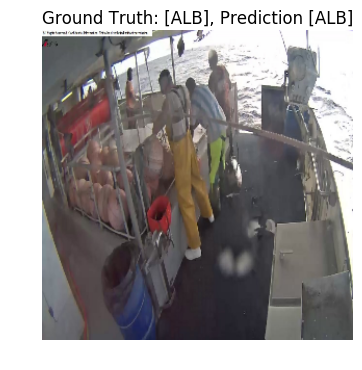

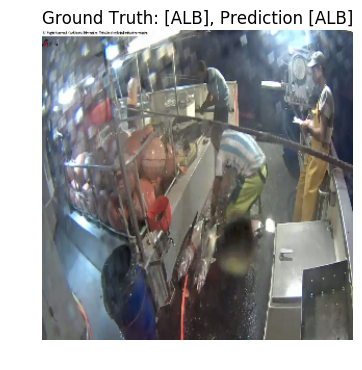

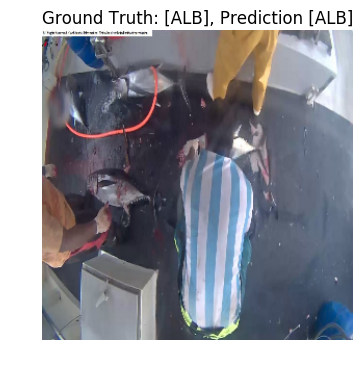

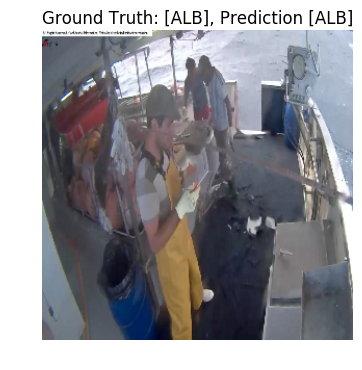

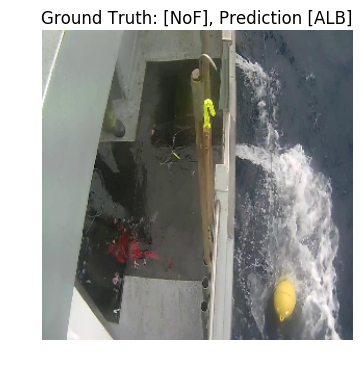

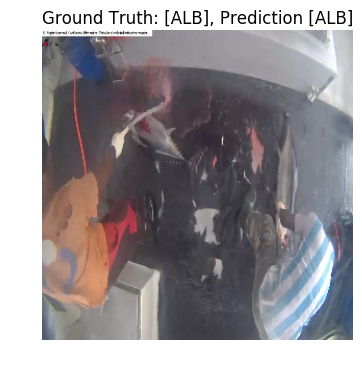

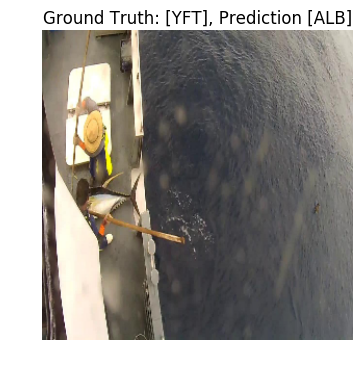

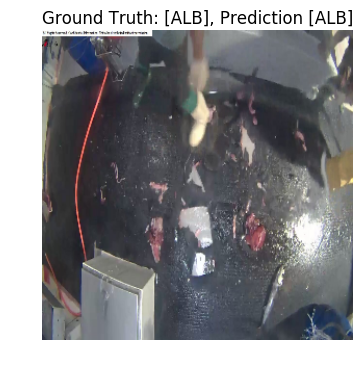

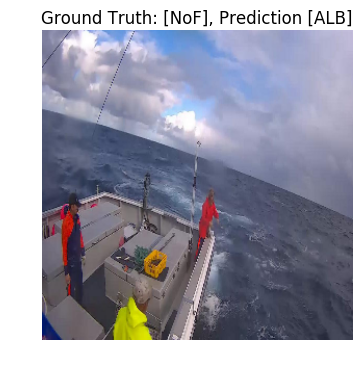

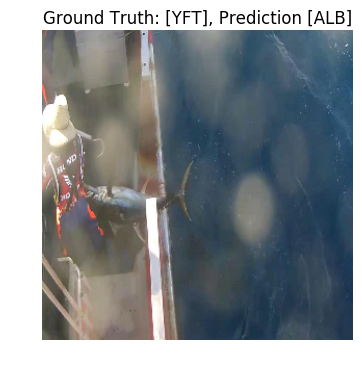

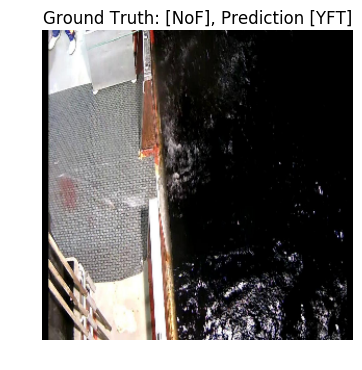

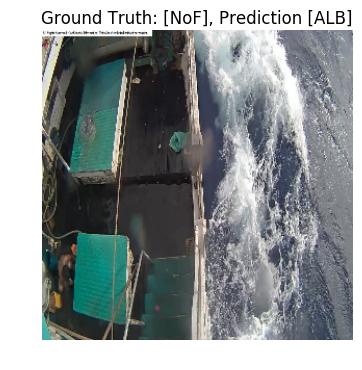

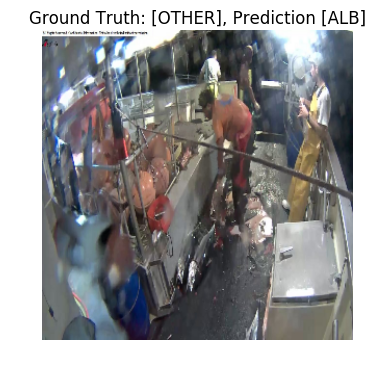

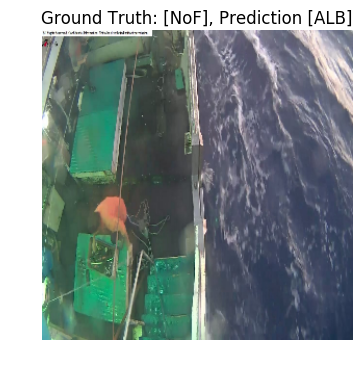

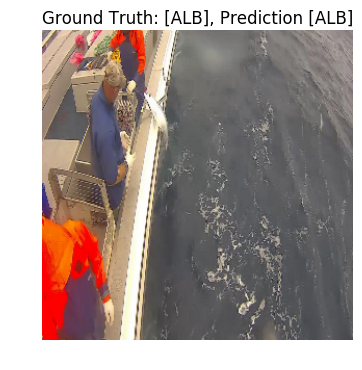

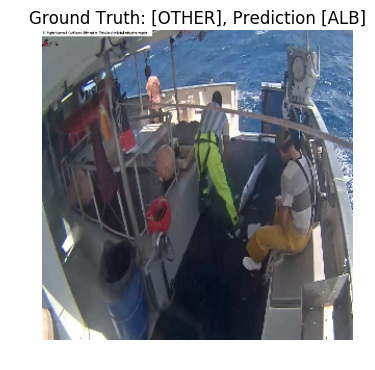

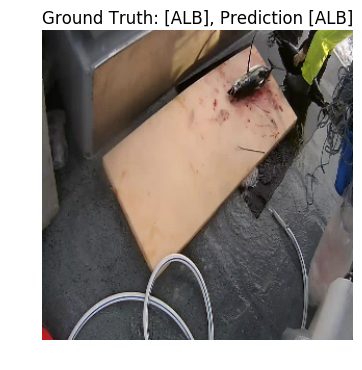

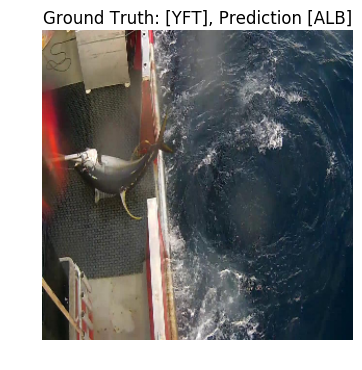

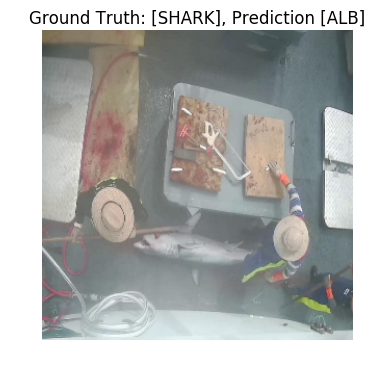

In [40]:
# Validate model
# label balance
import numpy as np
import tensorflow as tf
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v3.default_image_size
batch_size = 32
fish_data_dir = 'tmp/fish/dataset'
train_dir = 'tmp/fish/inception_finetuned/'


with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('validation', fish_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    # what's is_training means?
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=False)

    probabilities = tf.nn.softmax(logits)
    with tf.device('/cpu:0'):
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    log_loss = slim.losses.softmax_cross_entropy(logits, one_hot_labels)

    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    pred = np.zeros((dataset.num_samples, dataset.num_classes), dtype=np.float64)
    truth = np.zeros(dataset.num_samples, dtype=np.int32)
#     config = tf.ConfigProto(log_device_placement=True, device_count = {'gpu': 0})
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    fin_log_loss = 0
    with tf.Session(config=config) as sess:
        sess.run(tf.local_variables_initializer())
        init_fn(sess)
        with slim.queues.QueueRunners(sess):
                   
#             for j in range(int(dataset.num_samples/batch_size)):
#                 np_probabilities, np_images_raw, np_labels, np_log_loss = sess.run([probabilities, images_raw, labels, log_loss])
#                 pred[j*batch_size:(j+1)*batch_size, :] = np_probabilities
#                 truth[j*batch_size:(j+1)*batch_size] = np_labels
#                 fin_log_loss += np_log_loss
#     print("total_loss on validation dataset is %.4f" % (fin_log_loss/(dataset.num_samples/batch_size)))


            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]

                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()


In [ ]:
# convnet visualize

import numpy as np
import tensorflow as tf
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v3.default_image_size
batch_size = 32
fish_data_dir = 'tmp/fish/dataset'
train_dir = 'tmp/fish/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('validation', fish_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _convnet, _ = inception.inception_v3_base(images, final_endpoint='Conv2d_2b_3x3')
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_convnet, np_images_raw = sess.run([_convnet, images_raw])
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                convnet = np_convnet[i]
                vis_square(convnet.transpose(2, 0, 1))
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.axis('off')
                plt.show()
                

In [ ]:
#generate test dataset

#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
r"""Downloads and converts Flowers data to TFRecords of TF-Example protos.

This module downloads the Flowers data, uncompresses it, reads the files
that make up the Flowers data and creates two TFRecord datasets: one for train
and one for test. Each TFRecord dataset is comprised of a set of TF-Example
protocol buffers, each of which contain a single image and label.

The script should take about a minute to run.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
# import random
import sys

# import tensorflow as tf

from datasets import dataset_utils


# The number of shards per dataset split.
_NUM_SHARDS = 1


class ImageReader(object):
    """Helper class that provides TensorFlow image coding utilities."""

    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg,
                         feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image
    
def _get_filenames_and_classes_test(dataset_dir):
    """Returns a list of filenames and inferred class names.

    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.

    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
    directory = os.path.join(dataset_dir, 'test_stg1')
    photo_filenames = []
    for filename in os.listdir(directory):
        if filename.split('.')[-1] in ['jpg', 'png', 'jepg']:
            path = os.path.join(directory, filename)
            photo_filenames.append(path)

    return photo_filenames

def _get_dataset_filename_test(dataset_dir, shard_id):
    output_filename = 'fish_%s_%05d-of-%05d.tfrecord' % (
        "test", shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

def _convert_dataset_test(filenames, dataset_dir):
    """Converts the given filenames to a TFRecord dataset.

    Args:
    split_name: The name of the dataset, either 'train' or 'validation'.
    filenames: A list of absolute paths to png or jpg images.
    class_names_to_ids: A dictionary from class names (strings) to ids
      (integers).
    dataset_dir: The directory where the converted datasets are stored.
    """

    num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))
        
    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:
            for shard_id in range(_NUM_SHARDS):
                output_filename = _get_dataset_filename_test(dataset_dir, shard_id)

                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = shard_id * num_per_shard
                    end_ndx = min((shard_id+1) * num_per_shard, len(filenames))
                    for i in range(start_ndx, end_ndx):
                        sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                            i+1, len(filenames), shard_id))
                        sys.stdout.flush()

                        # Read the filename:
                        image_data = tf.gfile.FastGFile(filenames[i], 'r').read()
                        height, width = image_reader.read_image_dims(sess, image_data)


                        example = dataset_utils.image_to_tfexample_test(
                            image_data, b'jpg', height, width, bytes(filenames[i], 'utf8'))
                        tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()
    

def run_test(dataset_dir):
    """Runs the download and conversion operation.

    Args:
    dataset_dir: The dataset directory where the dataset is stored.
    """
    if not tf.gfile.Exists(dataset_dir):
        tf.gfile.MakeDirs(dataset_dir)

#     if _dataset_exists(dataset_dir):
#         print('Dataset files already exist. Exiting without re-creating them.')
#         return

#     dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)
    photo_filenames = _get_filenames_and_classes_test(dataset_dir)


    # First, convert the training and validation sets.
    _convert_dataset_test(photo_filenames, dataset_dir)

#     _clean_up_temporary_files(dataset_dir)
    print('\nFinished converting the fish dataset!')

# run_test('input')

In [31]:
# get test pred
import numpy as np
import tensorflow as tf
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v3.default_image_size
batch_size = 50
fish_data_dir = 'tmp/fish/dataset'
train_dir = 'tmp/fish/inception_finetuned/'


from preprocessing import inception_preprocessing


# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Provides data for the fish dataset.

The dataset scripts used to create the dataset can be found at:
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf

from datasets import dataset_utils
import math
slim = tf.contrib.slim

_FILE_PATTERN = 'fish_%s_*.tfrecord'

SPLITS_TO_SIZES = {'train': 2977, 'validation': 800, 'test': 1000}

_NUM_CLASSES = 8

_ITEMS_TO_DESCRIPTIONS = {
    'image': 'A color image of varying size.',
    'image_name': 'Name of images'
}


def get_split_test(split_name, dataset_dir, file_pattern=None, reader=None):
    """Gets a dataset tuple with instructions for reading fish.

    Args:
    split_name: A train/validation split name.
    dataset_dir: The base directory of the dataset sources.
    file_pattern: The file pattern to use when matching the dataset sources.
      It is assumed that the pattern contains a '%s' string so that the split
      name can be inserted.
    reader: The TensorFlow reader type.

    Returns:
    A `Dataset` namedtuple.

    Raises:
    ValueError: if `split_name` is not a valid train/validation split.
    """
    if split_name not in SPLITS_TO_SIZES:
        raise ValueError('split name %s was not recognized.' % split_name)

    if not file_pattern:
        file_pattern = _FILE_PATTERN
        file_pattern = os.path.join(dataset_dir, file_pattern % split_name)

    # Allowing None in the signature so that dataset_factory can use the default.
    if reader is None:
        reader = tf.TFRecordReader

    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
        'image/image_name': tf.FixedLenFeature((), tf.string, default_value=b''),
    }

    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(),
        'image_name': slim.tfexample_decoder.Tensor('image/image_name'),
    }

    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)

    labels_to_names = None
    if dataset_utils.has_labels(dataset_dir):
        labels_to_names = dataset_utils.read_label_file(dataset_dir)

    return slim.dataset.Dataset(
        data_sources=file_pattern,
        reader=reader,
        decoder=decoder,
        num_samples=SPLITS_TO_SIZES[split_name],
        items_to_descriptions=_ITEMS_TO_DESCRIPTIONS,
        num_classes=_NUM_CLASSES,
        labels_to_names=labels_to_names)


def load_batch_test(dataset, batch_size=50, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
#     data_provider = slim.dataset_data_provider.DatasetDataProvider(
#         dataset, common_queue_capacity=32,
#         common_queue_min=8)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset, common_queue_capacity=50, shuffle=False, num_epochs=1,
    common_queue_min=8)
    image_raw, image_name = data_provider.get(['image', 'image_name'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, image_name = tf.train.batch(
          [image, image_raw, image_name],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, image_name



batch_size = 40
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split_test('test', fish_data_dir)
    images, images_raw, image_name = load_batch_test(dataset, height=image_size, width=image_size, batch_size=batch_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    # what's is_training means?
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=False)

    probabilities = tf.nn.softmax(logits)
    
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    pred = np.zeros((dataset.num_samples, dataset.num_classes), dtype=np.float64)
    image_names = []
#     _config = tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0})
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.local_variables_initializer())
        init_fn(sess)
        with slim.queues.QueueRunners(sess):
            for j in range(int(dataset.num_samples/batch_size)):
                np_probabilities, np_images_raw, bytes_image_name = sess.run([probabilities, images_raw, image_name])
                start = j*batch_size
                end = np.minimum(start+batch_size, dataset.num_samples)
                pred[start: end, :] = np_probabilities
                image_names.extend(bytes_image_name)
                
print("generate test pred done")
#             np_probabilities, np_images_raw = sess.run([probabilities, images_raw])
#             for i in range(batch_size): 
#                 image = np_images_raw[i, :, :, :]
#                 predicted_label = np.argmax(np_probabilities[i, :])
#                 predicted_name = dataset.labels_to_names[predicted_label]

#                 plt.figure()
#                 plt.imshow(image.astype(np.uint8))
#                 plt.title('Prediction [%s]' % (predicted_name))
#                 plt.axis('off')
#                 plt.show()


generate test pred done


In [32]:
image_id = [i.decode('utf8').split(os.sep)[-1] for i in image_names]

submit = open('submit_inceptv3.csv','w')
submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')

for idx, id_n in enumerate(image_id):
    probs=['%.17f' % p for p in list(pred[idx, :])]
    submit.write('%s,%s\n' % (str(image_id[idx]),','.join(probs)))

submit.close()

In [33]:
len(image_names)

1000

In [1]:
def _get_filenames_and_classes(dataset_dir):
    """Returns a list of filenames and inferred class names.

    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.

    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
    fish_root = os.path.join(dataset_dir, 'train')
    directories = []
    class_names = []
    for filename in os.listdir(fish_root):
        path = os.path.join(fish_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.split('.')[-1] in ['jpg', 'png', 'jepg']:
                path = os.path.join(directory, filename)
                photo_filenames.append(path)

    return photo_filenames, sorted(class_names)

In [10]:
import os
dataset_dir = 'input'
fish_root = os.path.join(dataset_dir, 'train')
directories = []
class_names = []
for filename in os.listdir(fish_root):
    path = os.path.join(fish_root, filename)
    if os.path.isdir(path):
        directories.append(path)
        class_names.append(filename)

photo_lst = []
for directory in directories:
    lst_temp = []
    for filename in os.listdir(directory):
        if filename.split('.')[-1] in ['jpg', 'png', 'jepg']:
            path = os.path.join(directory, filename)
            lst_temp.append(path)
    photo_lst.append(lst_temp)


In [17]:
photo_filenames = []
for i in range(len(photo_lst[0])):
    for j in range(len(photo_lst)):
        index = j%(len(photo_lst[j]))
        photo_filenames.append(photo_lst[j][index])

[['input\\train\\ALB\\img_00003.jpg',
  'input\\train\\ALB\\img_00010.jpg',
  'input\\train\\ALB\\img_00012.jpg',
  'input\\train\\ALB\\img_00015.jpg',
  'input\\train\\ALB\\img_00019.jpg',
  'input\\train\\ALB\\img_00020.jpg',
  'input\\train\\ALB\\img_00029.jpg',
  'input\\train\\ALB\\img_00032.jpg',
  'input\\train\\ALB\\img_00037.jpg',
  'input\\train\\ALB\\img_00038.jpg',
  'input\\train\\ALB\\img_00039.jpg',
  'input\\train\\ALB\\img_00041.jpg',
  'input\\train\\ALB\\img_00043.jpg',
  'input\\train\\ALB\\img_00045.jpg',
  'input\\train\\ALB\\img_00055.jpg',
  'input\\train\\ALB\\img_00057.jpg',
  'input\\train\\ALB\\img_00074.jpg',
  'input\\train\\ALB\\img_00085.jpg',
  'input\\train\\ALB\\img_00090.jpg',
  'input\\train\\ALB\\img_00097.jpg',
  'input\\train\\ALB\\img_00110.jpg',
  'input\\train\\ALB\\img_00121.jpg',
  'input\\train\\ALB\\img_00130.jpg',
  'input\\train\\ALB\\img_00134.jpg',
  'input\\train\\ALB\\img_00136.jpg',
  'input\\train\\ALB\\img_00154.jpg',
  'input\\tr